### Graph ML for Chemical Compound Analysis: MUTAG Case Study

Author: Ludek Cizinsky (`ludek.cizinsky@epfl.ch`)

The philosophy of this notebook is to move all the implementation and helper functions into separate `.py` modules which are self-contained and can be used in other projects. This notebook is then used only for the purpose of running the experiments and visualizing the results. Please see the individual modules for more details.

Please note that for the purpose of the experiment tracking, `wandb` is used. The reason behind this choice is that there is no reason to reinvent the wheel and `wandb` provides a very nice interface for tracking the experiments. By defualt it is switched off so you should not need to worry about it. 

### Notebeook setup

#### Set notebook mode

In [1]:
NTB_MODE_TEST = True # True: test mode, False: train mode
USE_EDGE_FEAT = True

#### Jupyter notebook utils

In [2]:
%load_ext autoreload
%autoreload 2

#### Experiment logging (optional)

In [3]:
LOGEXP = False # This enables w&b logging
if LOGEXP:
    import os
    os.environ["WANDB_NOTEBOOK_NAME"] = "run.ipynb"

#### Dependencies import

In [4]:
# Hugging face util to download dataset
from datasets import load_dataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Numpy
import numpy as np

# Built-in
import random
from random import randint

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
# - Dataloader
from torch.utils.data import Dataset, DataLoader
# - Optimization
from torch.optim import Adam, SGD
# - Loss
from torch.nn import BCELoss, BCEWithLogitsLoss

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
colorstyle = "PuOr_r"
sns.set_palette(colorstyle)
cmap_nodes = sns.color_palette(colorstyle, as_cmap=True)

# Networkx
import networkx as nx

# Custom scripts
from scripts.dataset import GraphDataset
from scripts.layers import (
    # Normal
    GraphConv,
    # Graph Sage
    GraphSAGEConv,
    SumAggregation,
    SqrtDegAggregation,
    MaxPoolAggregation,
    # Graph Attention
    GraphAttentionConv,
    # Pooling
    MeanPool,
    MaxPool,
    # Edges
    GraphSumEdgeConv,
    GraphAttentionEdgeConv,
)

from scripts.architecture import (
    GNN
)

from scripts.utils import (
    train_and_evaluate,
    evaluate,
    get_ig_attributions,
    attr2color,
    plot_graph,
    get_feat_colors,
    get_feat_labels,
    plot_losses_and_f1s,
    plot_graph_with_attributions,
    plot_predictions,
)

/Users/ludekcizinsky/miniconda3/envs/cs502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the dataset from Hugging Face (HF)

In [5]:
# Download the dataset
dataset_hf = load_dataset("graphs-datasets/MUTAG")['train']

# Parse the dataset into X and y
X, y = [], []
for s in dataset_hf:
    X.append(s)
    y.extend(s['y'])

### Exploratory data analysis (EDA)

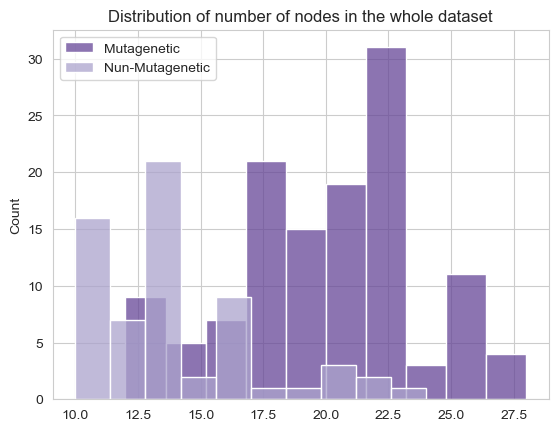

In [6]:
# Compute the number of nodes for each graph
num_nodes_pos = [g['num_nodes'] for g in X if g['y'][0] == 1]
num_nodes_neg = [g['num_nodes'] for g in X if g['y'][0] == 0]

fig, ax = plt.subplots()
sns.histplot(num_nodes_pos, ax=ax, bins=10, label='Mutagenetic');
sns.histplot(num_nodes_neg, ax=ax, bins=10, label='Nun-Mutagenetic');
ax.legend();

# Add labels
ax.set_title("Distribution of number of nodes in the whole dataset");

In [7]:
total = len(X)
print(f"Mutagenetic ({len(num_nodes_pos)}): {len(num_nodes_pos)/total:.2f}", f"Non-Mutagenetic ({len(num_nodes_neg)}): {len(num_nodes_neg)/total:.2f}")

Mutagenetic (125): 0.66 Non-Mutagenetic (63): 0.34


In [8]:
attributes = list(X[0].keys())
print(f"Available attributes: {attributes}")

Available attributes: ['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes']


### Train, validation and test split

In [9]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the train dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42)


# Show the sizes of the datasets
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)
total = n_train + n_val + n_test
print(f"Train ({n_train}): {n_train/total:.2f}", f"Val ({n_val}): {n_val/total:.2f}", f"Test ({n_test}): {n_test/total:.2f}")

Train (131): 0.70 Val (28): 0.15 Test (29): 0.15


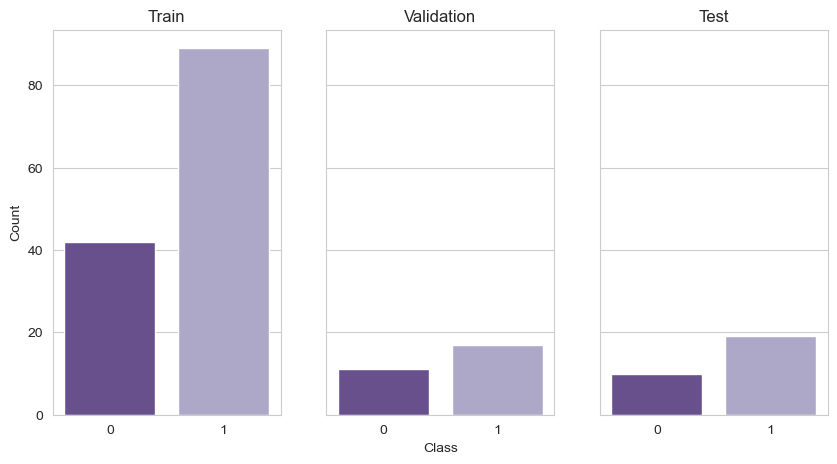

In [10]:
# Print class distribution
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharex=True, sharey=True)

# Training
sns.barplot(x=[0, 1], y=[y_train.count(0), y_train.count(1)], ax=axs[0]);
sns.barplot(x=[0, 1], y=[y_val.count(0), y_val.count(1)], ax=axs[1]);
sns.barplot(x=[0, 1], y=[y_test.count(0), y_test.count(1)], ax=axs[2]);

# Add labels
axs[0].set_title("Train")
axs[1].set_title("Validation")
axs[2].set_title("Test")

axs[0].set_ylabel("Count")
axs[1].set_xlabel("Class");

### Load data using custom dataloader

In [11]:
# Define hyperparameters for the dataloader
batch_size = 64

# Define custom stacking behavior for the dataloader
def collate_fn(batch):
    inputs, labels = [], []
    
    for item in batch:
        input_dict, label = item
        inputs.append(input_dict)
        labels.append(label)
    
    # Convert the list of labels to a 1D tensor
    labels = torch.tensor(labels).view(-1).type(torch.FloatTensor)
    
    return inputs, labels

# Define custom datasets
train_dataset = GraphDataset(X_train, y_train)
val_dataset = GraphDataset(X_val, y_val)
test_dataset = GraphDataset(X_test, y_test)

# Define custom dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

### Visualize the examples of sage and mutagenic molecules

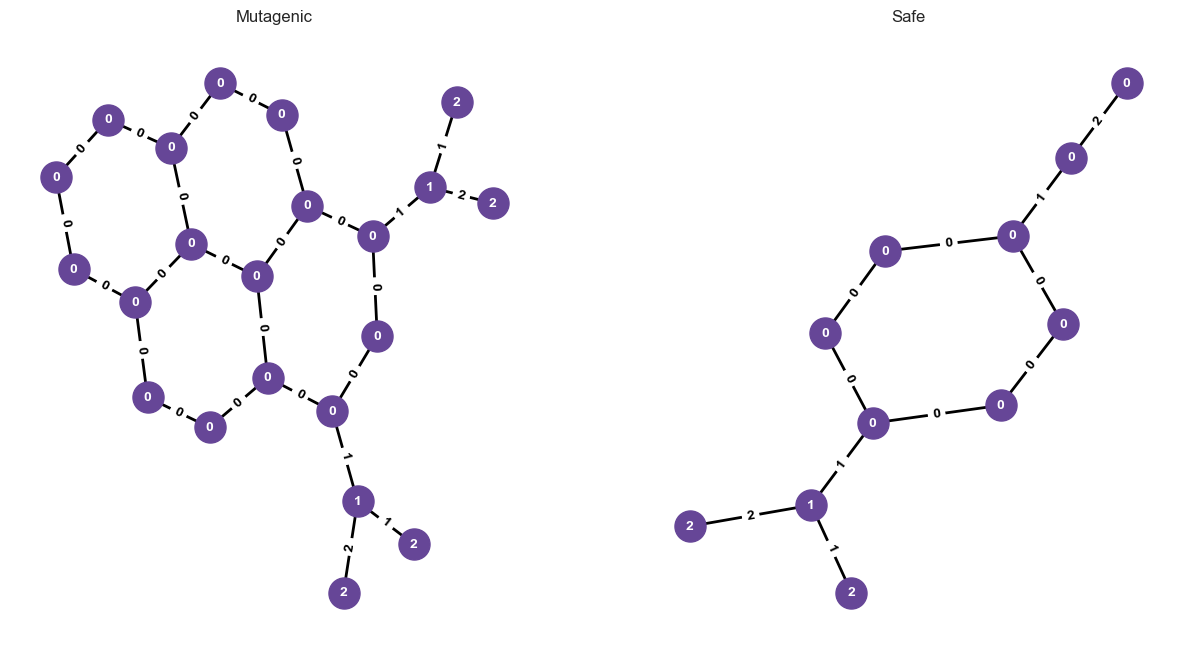

In [12]:
# From training data, get graphs with positive and negative labels
pos_graphs = [i for i, g in enumerate(X_train) if g['y'][0] == 1]
neg_graphs = [i for i, g in enumerate(X_train) if g['y'][0] == 0]

# Randomly select 1 graph from each class
pos_i, neg_i = randint(0, len(pos_graphs)-1), randint(0, len(neg_graphs)-1)
pos_graph = train_dataset[pos_graphs[pos_i]][0]
neg_graph = train_dataset[neg_graphs[neg_i]][0]

# Plot graphs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# - Positive
node_labels = get_feat_labels(pos_graph['node_features'])
edge_labels = get_feat_labels(pos_graph['edge_features'], pos_graph['edge_index'])
plot_graph(pos_graph['edge_index'], axs[0], node_labels, None, edge_labels, None)

# - Negative
node_labels = get_feat_labels(neg_graph['node_features'])
edge_labels = get_feat_labels(neg_graph['edge_features'], neg_graph['edge_index'])
plot_graph(neg_graph['edge_index'], axs[1], node_labels, None, edge_labels, None)

# Add labels
axs[0].set_title("Mutagenic")
axs[1].set_title("Safe");

### Network design

Epoch [47/100](0.3 s)
        Train Loss: 0.9967 Train F1(macro): 0.76
        Validation Loss: 0.2393 Validation F1(macro): 1.00

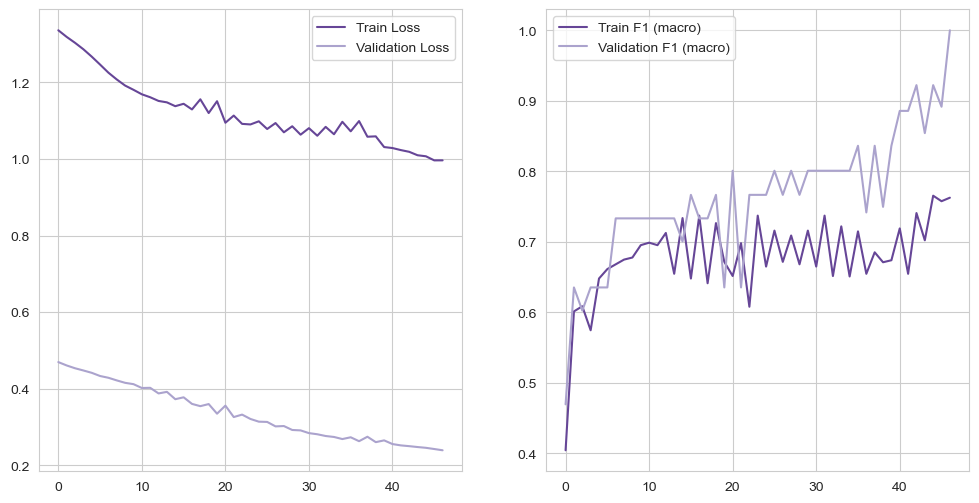

In [13]:
# ------------------- SETUP of experiment
# (1) USER DEFINED: the layers hyperparameters
# --- Global
activation = nn.LeakyReLU()
# --- Sage
aggregation = SumAggregation()
# --- Relevant for attention conv layer
global_softmax = True
# --- Relevant for attention edge conv layer
local_edge_agg = False


# (2) USER DEFINED: the model's architecture
# --- Node architecture
in_node_features = len(X_train[0]['node_feat'][0])
node_layers_dims = [in_node_features, 64, 64, 32]
node_layers_hyp = {
    'activation': activation,
    'softmax_global': global_softmax,
}
node_layer_type = GraphAttentionConv
node_architecture = [node_layer_type, node_layers_dims, node_layers_hyp]

# --- Edge architecture
if USE_EDGE_FEAT:
    in_edge_features = len(X_train[0]['edge_attr'][0])
    edge_layers_hyp = {
        'activation': activation,
        'local': local_edge_agg,
    }
    edge_layers_dims = [in_edge_features, 64, 64, 32] # All layers except the first one must be same as node layers
    edge_layer_type = GraphAttentionEdgeConv
    edge_architecture = [edge_layer_type, edge_layers_dims, edge_layers_hyp]
else:
    edge_architecture = None


# (3) USER DEFINED: the model's hyperparameters
pooling = MaxPool()
dropout = 0
model = GNN(node_architecture, pooling, dropout, edge_architecture).double()

# (4) USER DEFINED: training hyperparameters
lr = 1e-3
wd = 1e-6 # weight decay
epochs = 100
pos_weight = torch.Tensor([y_train.count(0)/y_train.count(1)])
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)
opt_name = "Adam"
if opt_name == "Adam":
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
elif opt_name == "SGD":
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=wd)

# ------------------- TRAINING given the setup
# (Optional) Log the setup of the experiment
if LOGEXP:
    # track hyperparameters and run metadata
    config = ( 
        {
            # Experiment Meta
            "experiment_type": "Nodes + Edges" if USE_EDGE_FEAT else "Nodes",
            "experiment_group": f"{node_layer_type.name} with {edge_layer_type.name}" if USE_EDGE_FEAT else f"{node_layer_type.name}" ,

            # Data
            "dataset": "MUTAG",
            "batch_size": batch_size,

            # Layers
            "Node layer": node_layer_type.name,
            "Edge layer": edge_layer_type.name if USE_EDGE_FEAT else None,
            "activation": str(activation) if activation is not None else None,
            "aggregation": str(aggregation) if node_layer_type.name == "GraphSAGEConv" else None,
            "global_softmax": global_softmax if node_layer_type.name == "GraphAttentionConv" else None,
            "local_edge_agg": local_edge_agg if USE_EDGE_FEAT and edge_layer_type.name == "GraphAttentionEdgeConv" else None,

            # Architecture
            "model_num_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
            "model_num_layers": len(node_layers_dims) + len(edge_layers_dims) if USE_EDGE_FEAT else len(node_layers_dims),
            "pooling": str(pooling),
            "dropout": dropout,

            # Training
            "epochs": epochs,
            "learning_rate": lr,
            "optimizer": opt_name,
            "weight_decay": wd,
            "pos_weight": pos_weight,
        }
    )
else:
    config = None

# Train the model
train_losses, train_f1s, val_losses, val_f1s, wandb = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs, config)

# Visualise the results
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Plot the losses
plot_losses_and_f1s(train_losses, train_f1s, axs, "Train")
plot_losses_and_f1s(val_losses, val_f1s, axs, "Validation")

if LOGEXP:
    wandb.log({"training_validation_curves": wandb.Image(plt)})

#### Inspect closer the performance on the validation dataset

Start by computing simple high level metrics on the validation dataset.

Val F1: 1.000
Val Accuracy: 1.000


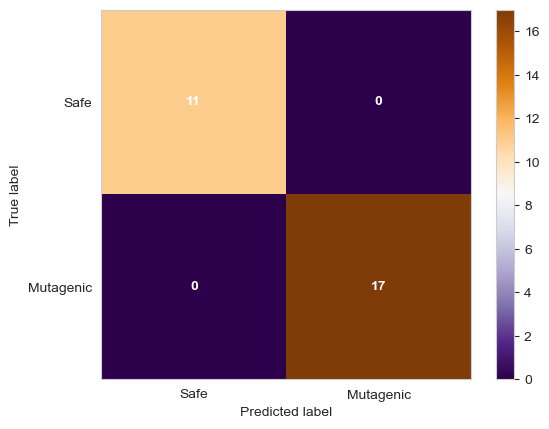

In [14]:
# Compute the test performance
_, val_f1, val_acc, val_true_pred = evaluate(model, val_loader, criterion)

# Print the test performance
print(f"Val F1: {val_f1:.3f}")
print(f"Val Accuracy: {val_acc:.3f}")

# Show the confusion matrix using sklearn
val_true, val_pred = val_true_pred

# Plot the confusion matrix
cm_val = confusion_matrix(val_true, val_pred)
display_val = ConfusionMatrixDisplay(cm_val, display_labels=["Safe", "Mutagenic"])
display_val = display_val.plot(cmap=sns.color_palette(colorstyle, as_cmap=True));
for text in display_val.text_.ravel():
    text.set_color('white')
    text.set_weight('bold')

plt.grid(False)

if LOGEXP:
    wandb.log({"Val Confusion Matrix": wandb.Image(plt)})


Continue by showing the `Intgrated Gradients` (influence of the input features on the output) for the validation dataset.

In [15]:
# Get indices of incorrect predictions for the mutagenicity
incorrect_mutagenic = [i for i, (true, pred) in enumerate(zip(val_true, val_pred)) if true == 1 and pred == 0]

if len(incorrect_mutagenic) == 0:
    print("No incorrect predictions for mutagenicity")
elif len(incorrect_mutagenic) >= 2:
    # Plot it
    fig, axs = plot_predictions(model, cmap_nodes, incorrect_mutagenic, val_dataset, 2)

    # Add title to the whole figure
    title = "Predicted as safe instead of mutagenic"
    fig.suptitle(title, fontsize=20);

if LOGEXP and len(incorrect_mutagenic) > 2:
    wandb.log({title: wandb.Image(plt)})

No incorrect predictions for mutagenicity


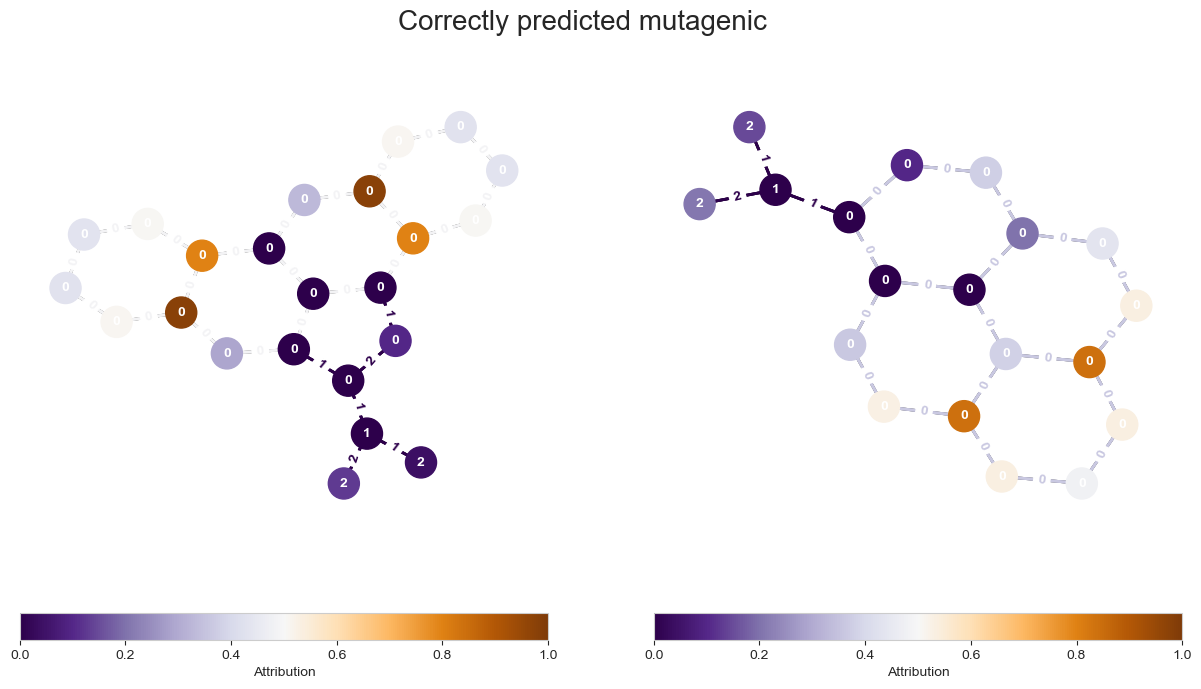

In [16]:
# Compute the indices of correct predictions for the mutagenic molecules
correct_mutagenic = [i for i, (true, pred) in enumerate(zip(val_true, val_pred)) if true == 1 and pred == 1]

# Plot it
fig, axs = plot_predictions(model, cmap_nodes, correct_mutagenic, val_dataset, 2)

# Add title to the whole figure
title = "Correctly predicted mutagenic"
fig.suptitle(title, fontsize=20);

if LOGEXP:
    wandb.log({title: wandb.Image(plt)})

In [37]:
# Compute the indices of incorrect predictions for the safe molecules
incorrect_safe = [i for i, (true, pred) in enumerate(zip(val_true, val_pred)) if true == 0 and pred == 1]

if len(incorrect_safe) == 0:
    print("No incorrect predictions for safety")
elif len(incorrect_safe) >= 2:
    # Plot it
    fig, axs = plot_predictions(model, cmap_nodes, incorrect_safe, val_dataset, 2)

    # Add title to the whole figure
    title = "Predicted as mutagenic instead of safe"
    fig.suptitle(title, fontsize=20);
else:
    print("Only 1 incorrect prediction for safety, thus no plot.")

if LOGEXP and len(incorrect_safe) > 2:
    wandb.log({title: wandb.Image(plt)})

No incorrect predictions for safety


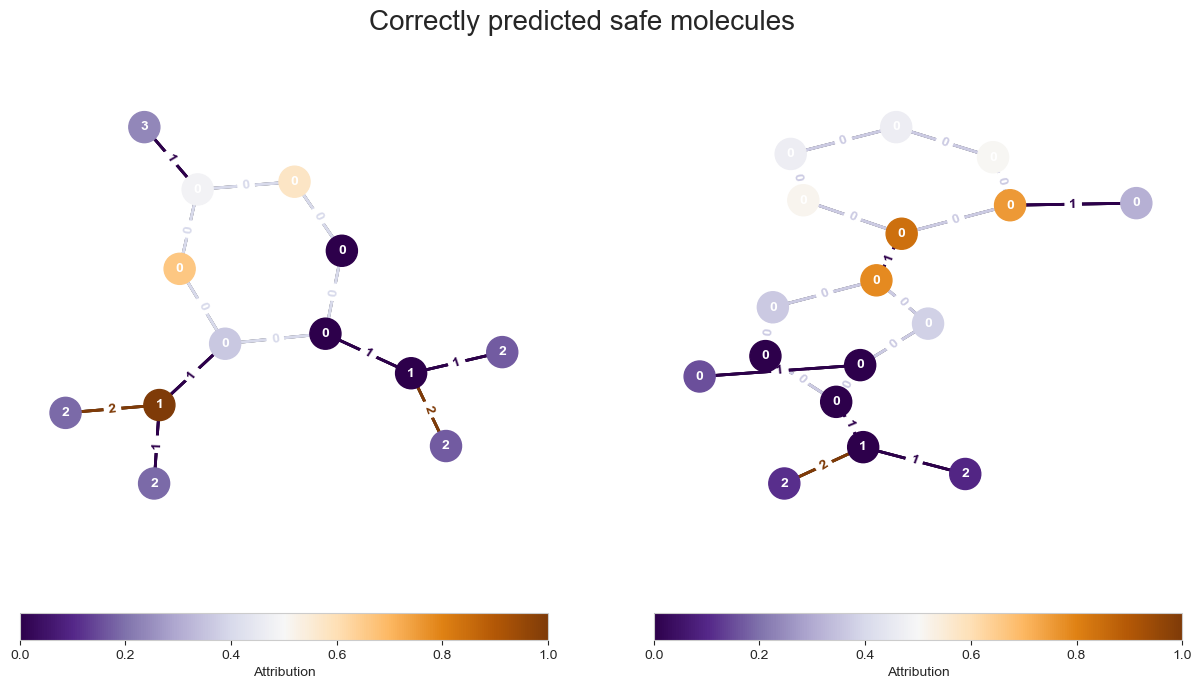

In [38]:
# Compute the indices of correct predictions for the safe molecules
correct_safe = [i for i, (true, pred) in enumerate(zip(val_true, val_pred)) if true == 0 and pred == 0]

# Plot it
fig, axs = plot_predictions(model, cmap_nodes, correct_safe, val_dataset, 2)

# Add title to the whole figure
title = "Correctly predicted safe molecules"
fig.suptitle(title, fontsize=20);

if LOGEXP:
    wandb.log({title: wandb.Image(plt)})

#### Evaluate the test performance

Test F1: 0.771
Test Accuracy: 0.793


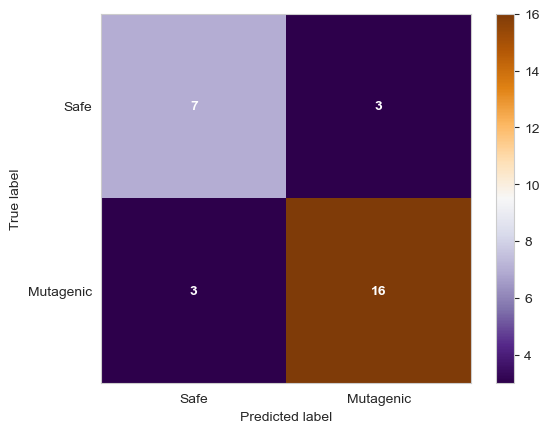

In [39]:
if NTB_MODE_TEST:
    # Compute the test performance
    _, test_f1, test_acc, test_true_pred = evaluate(model, test_loader, criterion)

    # Print the test performance
    print(f"Test F1: {test_f1:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Plot the confusion matrix
    test_true, test_pred = test_true_pred

    cm_test = confusion_matrix(test_true, test_pred)
    display_test = ConfusionMatrixDisplay(cm_test, display_labels=["Safe", "Mutagenic"])
    display_test = display_test.plot(cmap=sns.color_palette(colorstyle, as_cmap=True));
    for text in display_test.text_.ravel():
        text.set_color('white')
        text.set_weight('bold')

    plt.grid(False)

---